In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import datetime
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

In [ ]:
#read train, test and validation
train_line_cnt = 0
test_line_cnt = 0
valid_line_cnt = 0
train_line_lst = []
test_line_lst = []
val_line_lst = []

#SET.sent contains the sentences, one sentence per line.
with open("/content/drive/Shared drives/DSCI531/wikipedia-biography-dataset/train/train.sent") as f_tr:
    for line in f_tr:
        train_line_cnt += 1
        train_line_lst += [line]
print(train_line_cnt)

with open("/content/drive/Shared drives/DSCI531/wikipedia-biography-dataset/test/test.sent") as f_t:
    for line in f_t:
        test_line_cnt += 1
        test_line_lst += [line]
print(test_line_cnt)

with open("/content/drive/Shared drives/DSCI531/wikipedia-biography-dataset/valid/valid.sent") as f_v:
    for line in f_v:
        valid_line_cnt += 1
        val_line_lst += [line]
print(valid_line_cnt)

2395103
298900
299273


In [ ]:
#train sample
train_line_lst[:5]

['walter extra is a german award-winning aerobatic pilot , chief aircraft designer and founder of extra flugzeugbau -lrb- extra aircraft construction -rrb- , a manufacturer of aerobatic aircraft .\n',
 'extra was trained as a mechanical engineer .\n',
 'he began his flight training in gliders , transitioning to powered aircraft to perform aerobatics .\n',
 'he built and flew a pitts special aircraft and later built his own extra ea-230 .\n',
 'extra began designing aircraft after competing in the 1982 world aerobatic championships .\n']

In [ ]:
#train len
len(train_line_lst)

2395103

In [ ]:
#gerder word lists
gender_lst = ['she', 'her', 'hers', 'mommy', 'mom', 'girl', 'mother', 'lady', 'sister', 'mama', 'momma', 'sis', 'grandma', 'herself', \
              'woman', 'women', 'female', 'he', 'his', 'him', 'daddy', 'dad', 'boy', 'father', 'guy', 'brother', 'dada', 'papa', 'bro',
              'grandpa', 'himself', 'man', 'men', 'male']
female_lst = ['she', 'her', 'hers', 'mommy', 'mom', 'girl', 'mother', 'lady', 'sister', 'mama', 'momma', 'sis', 'grandma', 'herself', 'woman', \
              'women', 'female']
male_lst = ['he', 'his', 'him', 'daddy', 'dad', 'boy', 'father', 'guy', 'brother', 'dada', 'papa', 'bro', 'grandpa', 'himself', \
            'man', 'men', 'male']

In [ ]:
# change all text to lower case
train_line_lst = [x.lower() for x in train_line_lst]
test_line_lst = [x.lower() for x in test_line_lst]
val_line_lst = [x.lower() for x in val_line_lst]

In [ ]:
# First filter out the sentences with gender words for faster runtime later
filtered_train = [x for x in train_line_lst if any(word in x.split() for word in gender_lst)]
filtered_test = [x for x in test_line_lst if any(word in x.split() for word in gender_lst)]
filtered_val = [x for x in val_line_lst if any(word in x.split() for word in gender_lst)]

female_cnt = 0
male_cnt = 0
for i in filtered_train:
    if any(word in i.split() for word in female_lst) and any(word in i.split() for word in male_lst):
        continue
    elif any(word in i.split() for word in female_lst):
        female_cnt += 1
    elif any(word in i.split() for word in male_lst):
        male_cnt += 1
print(female_cnt)
print(male_cnt)

In [ ]:
#length of train, test, and val after filtering out sentences without gender words
print(len(filtered_train))
print(len(filtered_test))
print(len(filtered_val))

1349103
167707
168769


In [ ]:
#pip install nltk

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#word lists for good and bad categories
good_lst = ['happiness', 'happy', 'fun', 'fantastic', 'lovable', 'magical', 'delight', 'joy', 'relaxing', 'honest', 'excited', \
            'laughter', 'cheerful', 'great', 'moral', 'kindly', 'upright', 'worthy', 'outstanding', 'admirable', 'gracious',\
            'valuable', 'excellent', 'exceptional', 'superb', 'wonderful']
bad_lst = ['torture', 'murder', 'abuse', 'wreck', 'die', 'disaster', 'mourning', 'killer', 'nightmare', \
           'stress', 'kill', 'death', 'deficient', 'horrible', 'wrong', 'unsatisfactory', 'dreadful', 'flawed', 'useless', \
           'worthless', 'immoral', 'nefarious', 'sinful', 'unethical', 'harmful', 'hostile']

In [ ]:
#word lists for home and work categories
home_lst = ['baby', 'house', 'home', 'homes', 'wedding', 'kid', 'family', 'marry', 'domestic', 'household', 'households', \
            'chore', 'chores', 'families', 'kitchen', 'infant', 'babysit', 'childcare', 'parenting', 'garden', 'laundry',\
            'clean', 'cook']
work_lst = ['work', 'works', 'worked', 'labor', 'worker', 'workers', 'economy', 'office', 'job', 'jobs', 'business', 'businesses', \
            'trade', 'trades', 'company', 'companies', 'industry', 'industries', 'pay', 'pays', 'paid', 'working', 'salary', \
            'salaries', 'wage', 'wages', 'activity', 'act', 'money']

In [ ]:
#word lists for art, science, literature, and math categories

art_lst = ['art', 'artist', 'artwork', 'dance', 'dancing', 'dancer', 'sing', 'singing', 'singer', 'paint', 'painting', 'painter', 'song', 'draw', 'drawing', 'craft', 'handcraft', 'handicraft', 'music', 'sculpture', 'design', 'photography']
science_lst = ['science', 'scientist', 'chemistry', 'physics', 'engineer', 'space', 'spaceship', 'astronaut', 'chemical', 'microscope', 'theory', 'physics', 'medicine', 'engineering', 'biology', 'technology', 'astrophysics', 'biochemistry', 'geology', 'laboratory', 'radiology']
literature_lst = ['book','books', 'novel', 'read', 'write', 'story', 'word', 'writing', 'reading', 'tale', 'history', 'poetry', 'poem', 'poet', 'literacy', 'written', 'prose', 'fiction', 'essay', 'author']
math_lst = ['puzzle', 'number', 'count', 'math', 'counting', 'calculator', 'subtraction', 'addition', "arithmetic", "calculation", "calculus", "ciphering", "computation", "mathematics", "geometry", "algebra"]

In [ ]:
from nltk.corpus.reader.wordlist import NonbreakingPrefixesCorpusReader
#bert must take numberic attributes for label. Male -> 1, Female -> 0
def filer_gender(text):
    '''filter and replace for gender words'''
    if any(word in text.split() for word in female_lst) and any(word in text.split() for word in male_lst):
        return 'None'
    elif any(word in text.split() for word in female_lst):
        return 0
    elif any(word in text.split() for word in male_lst):
        return 1
    else:
        return 'None'

def filter_func1(text):
    '''filter and replace for good and bad categories'''
    if any(word in text.split() for word in good_lst) and any(word in text.split() for word in bad_lst):
        return 'None'
    elif any(word in text.split() for word in good_lst):
        return 'Good'
    elif any(word in text.split() for word in bad_lst):
        return 'Bad'
    else:
        return 'None'
  
def filter_func2(text):
    '''filter and replace for other categories'''
    if any(word in text.split() for word in home_lst):
        return 'home'
    elif any(word in text.split() for word in work_lst):
        return 'work'
    elif any(word in text.split() for word in art_lst):
        return 'art'
    elif any(word in text.split() for word in science_lst):
        return 'science'
    elif any(word in text.split() for word in literature_lst):
        return 'literature'
    elif any(word in text.split() for word in math_lst):
        return 'math'
    else:
        return 'None'

Generate dataframe for good & bad category label

In [ ]:
tmp1 = pd.DataFrame(filtered_train, columns = ['text'])
tmp1['gender'] = tmp1['text'].apply(filer_gender)
tmp1['category'] = tmp1['text'].apply(filter_func1)
labeled_train1 = tmp1[(tmp1['gender'] != 'None') & (tmp1['category'] != 'None')]
tmp2 = pd.DataFrame(filtered_test, columns = ['text'])
tmp2['gender'] = tmp2['text'].apply(filer_gender)
tmp2['category'] = tmp2['text'].apply(filter_func1)
labeled_test1 = tmp2[(tmp2['gender'] != 'None') & (tmp2['category'] != 'None')]
tmp3 = pd.DataFrame(filtered_val, columns = ['text'])
tmp3['gender'] = tmp3['text'].apply(filer_gender)
tmp3['category'] = tmp3['text'].apply(filter_func1)
labeled_val1 = tmp3[(tmp3['gender'] != 'None') & (tmp3['category'] != 'None')]
print(len(labeled_train1))
print(len(labeled_test1))
print(len(labeled_val1))

37009
4606
4657


In [ ]:
labeled_train1

,text,gender,category
4,she was a member of the district committee of ...,0,Bad
23,"on 5 november 1994 , he made english football ...",1,Bad
57,he was a national selector at the time of his ...,1,Bad
76,he believed his reputation as a hired killer w...,1,Bad
116,"he advocates immigration restrictions , the de...",1,Bad
...,...,...,...
1348762,"at the end of the 1960s , he had great success...",1,Good
1348901,hartono and his brother robert budi are the ow...,1,Bad
1348938,he was the gushie-na or gushie king until his ...,1,Bad
1349000,she represented great britain at the 2012 olym...,0,Good


Generate dataframe for other category labels

In [ ]:
tmp1 = pd.DataFrame(filtered_train, columns = ['text'])
tmp1['gender'] = tmp1['text'].apply(filer_gender)
tmp1['category'] = tmp1['text'].apply(filter_func2)
labeled_train2 = tmp1[(tmp1['gender'] != 'None') & (tmp1['category'] != 'None')]
tmp2 = pd.DataFrame(filtered_test, columns = ['text'])
tmp2['gender'] = tmp2['text'].apply(filer_gender)
tmp2['category'] = tmp2['text'].apply(filter_func2)
labeled_test2 = tmp2[(tmp2['gender'] != 'None') & (tmp2['category'] != 'None')]
tmp3 = pd.DataFrame(filtered_val, columns = ['text'])
tmp3['gender'] = tmp3['text'].apply(filer_gender)
tmp3['category'] = tmp3['text'].apply(filter_func2)
labeled_val2 = tmp3[(tmp3['gender'] != 'None') & (tmp3['category'] != 'None')]
print(len(labeled_train2))
print(len(labeled_test2))
print(len(labeled_val2))

270052
33506
33585


In [ ]:
labeled_train2

,text,gender,category
7,he currently works as a fitness trainer .\n,1,work
8,he was recruited from east perth whom he playe...,1,literature
13,"following his retirement from afl football , s...",1,work
15,he left the saints before the 2007 season citi...,1,home
17,walter 's early footballing experience came wh...,1,home
...,...,...,...
1349087,eddy c. bertin is a belgian author of adult an...,1,science
1349088,he has also written under the pseudonyms edith...,1,literature
1349089,her works include composition for the video ga...,0,work
1349090,"in addition to video game music , she has comp...",0,art


In [ ]:
# !pip install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 53.9 MB/s 
     |████████████████████████████████| 895 kB 49.7 MB/s 
     |████████████████████████████████| 6.6 MB 43.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenizeData(data, tokenizer, MAX_LEN): 
    """
    Tokenize data, mask gender words. 
    Return the data tokenized and padded to MAX_LEN with the attension masks 

    """
    sentences = [[x if x not in gender_lst else "[MASK]" for x in sent] for sent in data]
    input_ids = []
    attention_masks = []
    for sent in sentences: 
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.                   
        )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## GOOD & BAD: Data Prep

In [ ]:
train_x_1, train_y_1 = labeled_train1["text"], labeled_train1["gender"].to_list()
val_x_1, val_y_1 = labeled_val1["text"], labeled_val1["gender"].to_list()
test_x_1, test_y_1 = labeled_test1["text"], labeled_test1["gender"].to_list()

In [ ]:
#tokenize for dataframe 1 with good and bad category
train_x_1, train_mask_1 = tokenizeData(train_x_1, tokenizer, MAX_LEN = 128)
val_x_1, val_mask_1 = tokenizeData(val_x_1, tokenizer, MAX_LEN = 128)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# change labels to tensors 
train_y_1 = torch.tensor(train_y_1)
val_y_1 = torch.tensor(val_y_1)

In [ ]:
# chagne to tensor dataset
train_1 = TensorDataset(train_x_1, train_mask_1, train_y_1)
val_1 = TensorDataset(val_x_1, val_mask_1, val_y_1)

In [ ]:
# load the data
train_dataloader = DataLoader(train_1, batch_size=32)
val_dataloader = DataLoader(val_1, batch_size=32)

### BERT Model: GOOD & BAD

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model_1 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model_1.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# calculate accuracy 
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# calculate time 
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#save model
def saveModel(model, tokenizer, output_dir): 
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print("Saving model to {}".format(output_dir))
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print("Done!")

In [ ]:
# optimizer and learning rate scheduler 
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model_1.parameters(), 
                lr = 1e-5, 
                eps = 1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# training loop 
training_stats_1 = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model_1.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model_1.zero_grad()        
        result = model_1(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model_1.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.6f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model_1.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            result = model_1(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.4f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # save the model 
    saveModel(model_1, tokenizer, "epoch_{}".format(epoch_i+1))

    # Record all statistics from this epoch.
    training_stats_1.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,157.    Elapsed: 0:00:21.
  Batch   200  of  1,157.    Elapsed: 0:00:42.
  Batch   300  of  1,157.    Elapsed: 0:01:02.
  Batch   400  of  1,157.    Elapsed: 0:01:23.
  Batch   500  of  1,157.    Elapsed: 0:01:44.
  Batch   600  of  1,157.    Elapsed: 0:02:04.
  Batch   700  of  1,157.    Elapsed: 0:02:25.
  Batch   800  of  1,157.    Elapsed: 0:02:46.
  Batch   900  of  1,157.    Elapsed: 0:03:07.
  Batch 1,000  of  1,157.    Elapsed: 0:03:27.
  Batch 1,100  of  1,157.    Elapsed: 0:03:48.

  Average training loss: 0.193509
  Training epcoh took: 0:04:00

Running Validation...
  Accuracy: 0.9517
  Validation Loss: 0.13
  Validation took: 0:00:09
Saving model to epoch_1
Done!

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,157.    Elapsed: 0:00:21.
  Batch   200  of  1,157.    Elapsed: 0:00:41.
  Batch   300  of  1,157.    Elapsed: 0:01:02.
  Batch   400  of  1,157.    Elapsed: 0:01:23.
  Batch   500  of  1

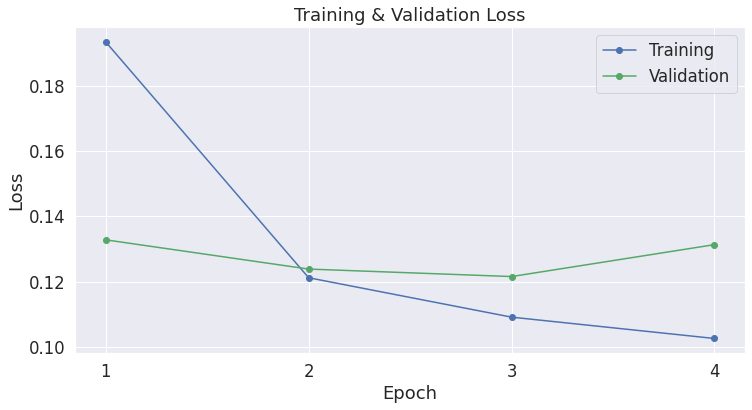

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
stats_1 = pd.DataFrame(data=training_stats_1)

# Use the 'epoch' as the row index.
stats_1 = stats_1.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
stats_1
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(stats_1['Training Loss'], 'b-o', label="Training")
plt.plot(stats_1['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#test

In [ ]:
# load model epoch 2
model_1 = BertForSequenceClassification.from_pretrained("epoch_2")
tokenizer_1 = BertTokenizer.from_pretrained("epoch_2")
model_1.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
test_x_1, test_mask_1 = tokenizeData(test_x_1, tokenizer_1, MAX_LEN = 128)
test_y_1 = torch.tensor(test_y_1)
test_1 = TensorDataset(test_x_1, test_mask_1, test_y_1)
test_loader_1 = DataLoader(test_1, batch_size=4000)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# import gc

# gc.collect()

# torch.cuda.empty_cache()

In [ ]:
model_1.eval()
predictions_1 = []
ground_truth_1 = []
for batch in test_loader_1: 
    # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model_1(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_1.append(logits)
  ground_truth_1.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
np.save("test_1_prediction_pretrained.npy", predictions_1[0])
np.save("test_1_labels.npy", ground_truth_1[0])
pred_1 = [np.argmax(x) for x in predictions_1[0]]

In [ ]:
#calculate the confusion matrix, f1, recall and precision
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_curve, precision_score, recall_score
confusion_matrix_1 = confusion_matrix(ground_truth_1[0], pred_1)
f1 = f1_score(ground_truth_1[0], pred_1)
precision = precision_score(ground_truth_1[0], pred_1)
recall = recall_score(ground_truth_1[0], pred_1)
print(f1, precision, recall)

0.9726711724948575 0.9516963772282921 0.9945913461538461


In [ ]:
confusion_matrix_1

array([[ 504,  168],
       [  18, 3310]])

In [ ]:
result_1 = labeled_test1.drop(labeled_test1.columns[0], axis=1)
result_1["gender"]=result_1["gender"].apply(lambda x: "Male" if x == 1 else "Female")
result_1

,gender,category
11,Male,Good
16,Male,Bad
41,Male,Good
84,Male,Bad
89,Male,Bad
...,...,...
167569,Male,Bad
167570,Male,Bad
167586,Male,Good
167651,Male,Bad


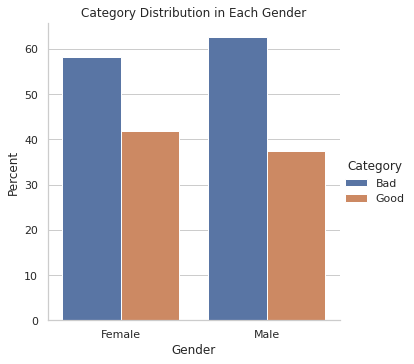

In [ ]:
diff_sex_1=result_1.groupby(["gender","category"]).size().reset_index()
diff_sex_1 = diff_sex_1.set_axis(['Gender', 'Category', 'Percent'], axis=1, inplace=False)
diff_sex_1['total'] = diff_sex_1.groupby(['Gender']).transform('sum')['Percent']
diff_sex_1.Percent= diff_sex_1.Percent/diff_sex_1.total * 100
sns.set_theme(style="whitegrid")
#test = sns.load_dataset("test")
plt_diff_sex_1 = sns.catplot(x="Gender", y="Percent",hue="Category",kind="bar", data=diff_sex_1)
plt_diff_sex_1.set(title='Category Distribution in Each Gender')

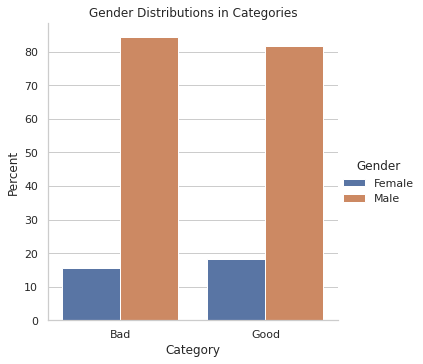

In [ ]:
diff_cat_1= result_1.groupby(["category", "gender"]).size().reset_index()
diff_cat_1 = diff_cat_1.set_axis(['Category', 'Gender', 'Percent'], axis=1, inplace=False)
grouped_diff_cat_1=diff_cat_1.groupby("Category").sum().reset_index()
grouped_diff_cat_1=grouped_diff_cat_1["Percent"].values
grouped_diff_cat_1=np.repeat(grouped_diff_cat_1,2)
a=pd.Series(grouped_diff_cat_1)
diff_cat_1["sum"]=grouped_diff_cat_1
def prep2(x):
    x[2]=x[2]/x[3]
    return x
diff_cat_1=diff_cat_1.apply(lambda x: prep2(x), axis=1)


diff_cat_1.Percent=diff_cat_1.Percent.apply(lambda x: x*100)
sns.set_theme(style="whitegrid")
#test = sns.load_dataset("test")
plt_diff_cat_1 = sns.catplot(x="Category", y="Percent",hue="Gender",kind="bar", data=diff_cat_1)
plt_diff_cat_1.set(title='Gender Distributions in Categories')

In [ ]:
# diff_sex_1=result_1.groupby(["gender","category"]).size().reset_index()
# diff_sex_1 = diff_sex_1.set_axis(['Gender', 'Category', 'Percent'], axis=1, inplace=False)
# # grouped_diff_sex_1 = diff_sex_1.groupby("Gender").sum().reset_index()
# diff_sex_1['total'] = diff_sex_1.groupby(['Gender']).transform('sum')['Percent']
# diff_sex_1.Percent= diff_sex_1.Percent/diff_sex_1.total
# diff_sex_1

,Gender,Category,Percent,total
0,Female,Bad,0.581699,765
1,Female,Good,0.418301,765
2,Male,Bad,0.626399,3841
3,Male,Good,0.373601,3841


#### Other Categories: Data prep

In [ ]:
train_x_2, train_y_2 = labeled_train2["text"], labeled_train2["gender"].to_list()
val_x_2, val_y_2 = labeled_val2["text"], labeled_val2["gender"].to_list()
test_x_2, test_y_2 = labeled_test2["text"], labeled_test2["gender"].to_list()

In [ ]:
#tokenize for dataframe 2 with good and bad category
train_x_2, train_mask_2 = tokenizeData(train_x_2, tokenizer, MAX_LEN = 512)
val_x_2, val_mask_2 = tokenizeData(val_x_2, tokenizer, MAX_LEN = 512)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# change labels to tensors 
train_y_2 = torch.tensor(train_y_2)
val_y_2 = torch.tensor(val_y_2)

In [ ]:
# chagne to tensor dataset
train_2 = TensorDataset(train_x_2, train_mask_2, train_y_2)
val_2 = TensorDataset(val_x_2, val_mask_2, val_y_2)

In [ ]:
# load the data
train_dataloader_2 = DataLoader(train_2, batch_size=128)
val_dataloader_2 = DataLoader(val_2, batch_size=128)

### BERT Model: Other Categories

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model_2 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 2-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model_2.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# optimizer and learning rate scheduler 
from transformers import get_linear_schedule_with_warmup
optimizer_2 = AdamW(model_2.parameters(), 
                lr = 1e-5, 
                eps = 1e-8)
epochs_2 = 6
total_steps_2 = len(train_dataloader_2) * epochs_2
scheduler_2 = get_linear_schedule_with_warmup(optimizer_2, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps_2)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# training loop 
training_stats_2 = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs_2):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs_2))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model_2.train()

    for step, batch in enumerate(train_dataloader_2):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_2), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model_2.zero_grad()        
        result = model_2(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model_2.parameters(), 1.0)
        optimizer_2.step()
        scheduler_2.step()

    avg_train_loss = total_train_loss / len(train_dataloader_2)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.6f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model_2.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader_2:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            result = model_2(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader_2)
    print("  Accuracy: {0:.4f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader_2)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # save the model 
    saveModel(model_2, tokenizer, "model2_epoch_{}".format(epoch_i+1))

    # Record all statistics from this epoch.
    training_stats_2.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 6 ========
Training...
  Batch   100  of  2,110.    Elapsed: 0:01:12.
  Batch   200  of  2,110.    Elapsed: 0:02:23.
  Batch   300  of  2,110.    Elapsed: 0:03:34.
  Batch   400  of  2,110.    Elapsed: 0:04:45.
  Batch   500  of  2,110.    Elapsed: 0:05:56.
  Batch   600  of  2,110.    Elapsed: 0:07:07.
  Batch   700  of  2,110.    Elapsed: 0:08:18.
  Batch   800  of  2,110.    Elapsed: 0:09:29.
  Batch   900  of  2,110.    Elapsed: 0:10:40.
  Batch 1,000  of  2,110.    Elapsed: 0:11:51.
  Batch 1,100  of  2,110.    Elapsed: 0:13:02.
  Batch 1,200  of  2,110.    Elapsed: 0:14:13.
  Batch 1,300  of  2,110.    Elapsed: 0:15:24.
  Batch 1,400  of  2,110.    Elapsed: 0:16:35.
  Batch 1,500  of  2,110.    Elapsed: 0:17:46.
  Batch 1,600  of  2,110.    Elapsed: 0:18:57.
  Batch 1,700  of  2,110.    Elapsed: 0:20:07.
  Batch 1,800  of  2,110.    Elapsed: 0:21:18.
  Batch 1,900  of  2,110.    Elapsed: 0:22:29.
  Batch 2,000  of  2,110.    Elapsed: 0:23:40.
  Batch 2,100  of

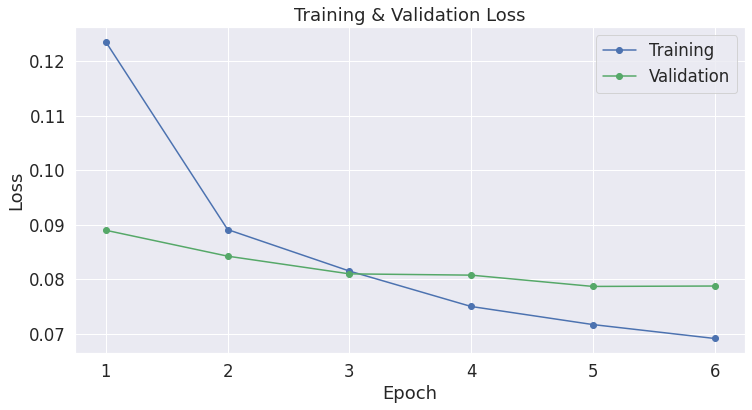

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
stats_2 = pd.DataFrame(data=training_stats_2)

# Use the 'epoch' as the row index.
stats_2 = stats_2.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
stats_2
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(stats_2['Training Loss'], 'b-o', label="Training")
plt.plot(stats_2['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6])

plt.show()

In [ ]:
#test

In [ ]:
# load model epoch 2
model_2 = BertForSequenceClassification.from_pretrained("model2_epoch_5")
tokenizer_2 = BertTokenizer.from_pretrained("model2_epoch_5")
model_2.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
test_x_2, test_mask_2 = tokenizeData(test_x_2, tokenizer_2, MAX_LEN = 512)
test_y_2 = torch.tensor(test_y_2)
test_2 = TensorDataset(test_x_2, test_mask_2, test_y_2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
test_loader_2 = DataLoader(test_2, batch_size=1000)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
model_2.eval()
predictions_2 = []
ground_truth_2 = []
for batch in test_loader_2: 
    # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model_2(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_2.append(logits)
  ground_truth_2.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
np.save("test_2_prediction_pretrained.npy", predictions_2[0])
np.save("test_2_labels.npy", ground_truth_2[0])
pred_2 = [np.argmax(x) for x in predictions_2[0]]

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_curve, precision_score, recall_score
confusion_matrix_2 = confusion_matrix(ground_truth_2[0], pred_2)
f1_2 = f1_score(ground_truth_2[0], pred_2)
precision_2 = precision_score(ground_truth_2[0], pred_2)
recall_2 = recall_score(ground_truth_2[0], pred_2)
print(f1_2, precision_2, recall_2)

0.9849246231155778 0.9763387297633873 0.9936628643852978


In [ ]:
confusion_matrix_2

array([[192,  19],
       [  5, 784]])

In [ ]:
result_2 = labeled_test2.drop(labeled_test2.columns[0], axis=1)
result_2["gender"]=result_2["gender"].apply(lambda x: "Male" if x == 1 else "Female")
result_2

,gender,category
4,Male,science
11,Male,work
12,Male,work
15,Male,home
18,Male,art
...,...,...
167675,Male,literature
167678,Female,art
167681,Female,work
167698,Male,work


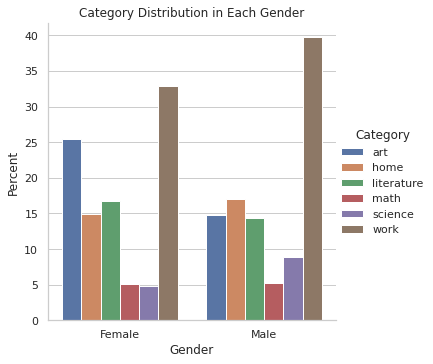

In [ ]:
diff_sex_2=result_2.groupby(["gender","category"]).size().reset_index()
diff_sex_2 = diff_sex_2.set_axis(['Gender', 'Category', 'Percent'], axis=1, inplace=False)
diff_sex_2['total'] = diff_sex_2.groupby(['Gender']).transform('sum')['Percent']
diff_sex_2.Percent= diff_sex_2.Percent/diff_sex_2.total * 100
sns.set_theme(style="whitegrid")
#test = sns.load_dataset("test")
plt_diff_sex_2 = sns.catplot(x="Gender", y="Percent",hue="Category",kind="bar", data=diff_sex_2)
plt_diff_sex_2.set(title='Category Distribution in Each Gender')

In [ ]:
# diff_sex_2=result_2.groupby(["gender","category"]).size().reset_index()
# diff_sex_1 = diff_sex_1.set_axis(['Gender', 'Category', 'Percent'], axis=1, inplace=False)
# diff_sex_1['total'] = diff_sex_1.groupby(['Gender']).transform('sum')['Percent']
# diff_sex_1.Percent= diff_sex_1.Percent/diff_sex_1.total * 100

NameError: ignored

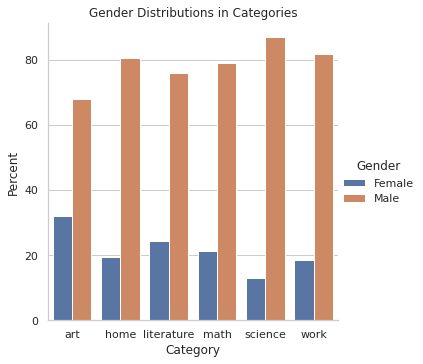

In [ ]:
diff_cat_2= result_2.groupby(["category", "gender"]).size().reset_index()
diff_cat_2 = diff_cat_2.set_axis(['Category', 'Gender', 'Percent'], axis=1, inplace=False)
grouped_diff_cat_2=diff_cat_2.groupby("Category").sum().reset_index()
grouped_diff_cat_2=grouped_diff_cat_2["Percent"].values
grouped_diff_cat_2=np.repeat(grouped_diff_cat_2,2)
a=pd.Series(grouped_diff_cat_2)
diff_cat_2["sum"]=grouped_diff_cat_2
def prep2(x):
    x[2]=x[2]/x[3]
    return x
diff_cat_2=diff_cat_2.apply(lambda x: prep2(x), axis=1)


diff_cat_2.Percent=diff_cat_2.Percent.apply(lambda x: x*100)
sns.set_theme(style="whitegrid")
#test = sns.load_dataset("test")
plt_diff_cat_2 = sns.catplot(x="Category", y="Percent",hue="Gender",kind="bar", data=diff_cat_2)
plt_diff_cat_2.set(title='Gender Distributions in Categories')